# 论文11：通过膨胀卷积进行多尺度上下文聚合
## Fisher Yu, Vladlen Koltun (2015)

### 膨胀/空洞卷积用于大感受野

在不损失分辨率或不增加参数的情况下扩大感受野！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 标准卷积 vs 膨胀卷积

**标准卷积**：连续的核
**膨胀卷积**：带间隙的核（膨胀率）

In [2]:
def dilated_conv1d(input_seq, kernel, dilation=1):
    """
    1D dilated convolution
    
    dilation=1: standard convolution
    dilation=2: skip every other position
    dilation=4: skip 3 positions
    """
    input_len = len(input_seq)
    kernel_len = len(kernel)
    
    # Effective kernel size with dilation
    effective_kernel_len = (kernel_len - 1) * dilation + 1
    output_len = input_len - effective_kernel_len + 1
    
    output = []
    for i in range(output_len):
        # Apply dilated kernel
        result = 0
        for k in range(kernel_len):
            pos = i + k * dilation
            result += input_seq[pos] * kernel[k]
        output.append(result)
    
    return np.array(output)

# Test
signal = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
kernel = np.array([1, 1, 1])

out_d1 = dilated_conv1d(signal, kernel, dilation=1)
out_d2 = dilated_conv1d(signal, kernel, dilation=2)
out_d4 = dilated_conv1d(signal, kernel, dilation=4)

print(f"Input: {signal}")
print(f"Kernel: {kernel}")
print(f"\nDilation=1 (standard): {out_d1}")
print(f"Dilation=2: {out_d2}")
print(f"Dilation=4: {out_d4}")
print(f"\nReceptive field grows exponentially with dilation!")

Input: [ 1  2  3  4  5  6  7  8  9 10]
Kernel: [1 1 1]

Dilation=1 (standard): [ 6  9 12 15 18 21 24 27]
Dilation=2: [ 9 12 15 18 21 24]
Dilation=4: [15 18]

Receptive field grows exponentially with dilation!


## 可视化感受野

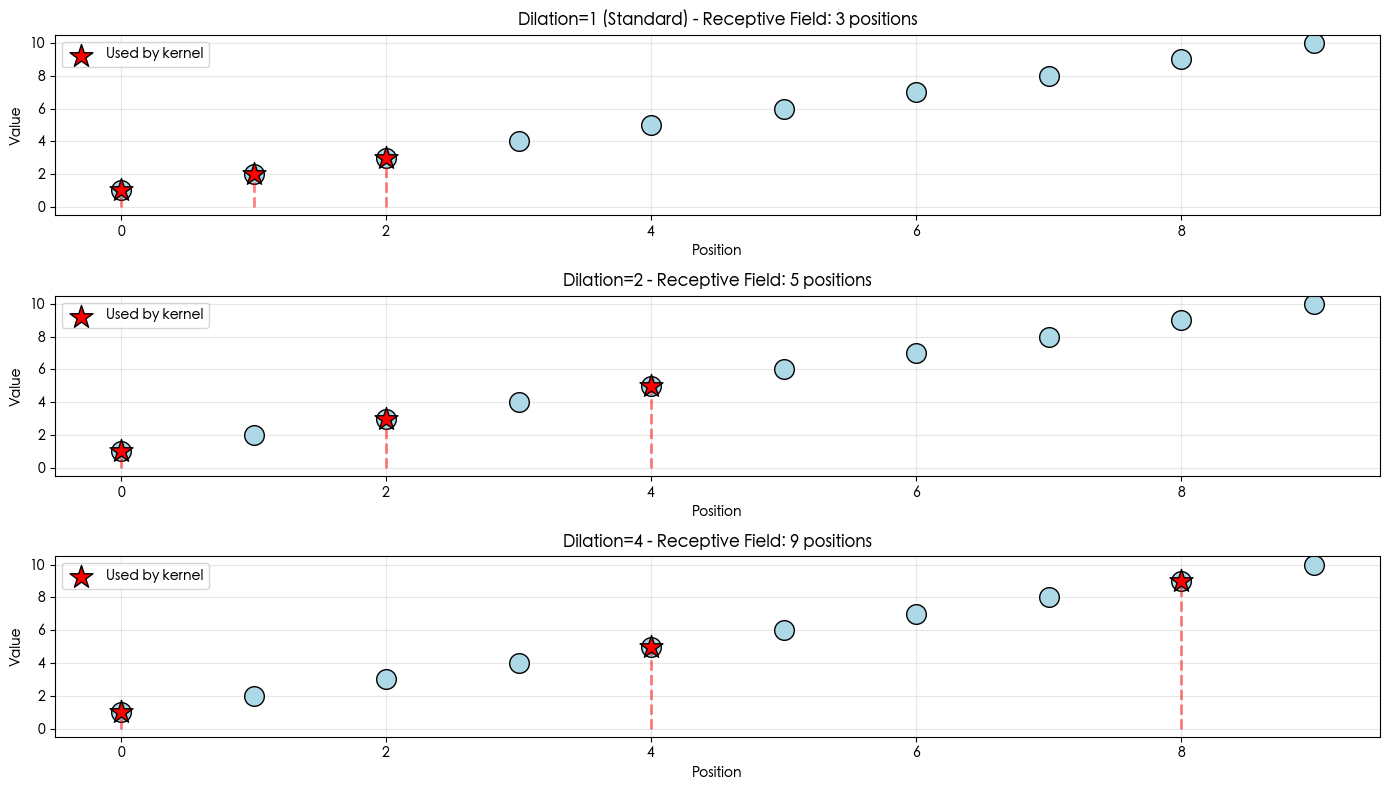

In [3]:
# Visualize how dilation affects receptive field
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

for ax, dilation, title in zip(axes, [1, 2, 4], 
                                ['Dilation=1 (Standard)', 'Dilation=2', 'Dilation=4']):
    # Show which positions are used
    positions = [0, dilation, 2*dilation]
    
    ax.scatter(range(10), signal, s=200, c='lightblue', edgecolors='black', zorder=2)
    ax.scatter(positions, signal[positions], s=300, c='red', edgecolors='black', 
              marker='*', zorder=3, label='Used by kernel')
    
    # Draw connections
    for pos in positions:
        ax.plot([pos, pos], [0, signal[pos]], 'r--', alpha=0.5, linewidth=2)
    
    ax.set_title(f'{title} - Receptive Field: {1 + 2*dilation} positions')
    ax.set_xlabel('Position')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 9.5)

plt.tight_layout()
plt.show()

## 2D 膨胀卷积

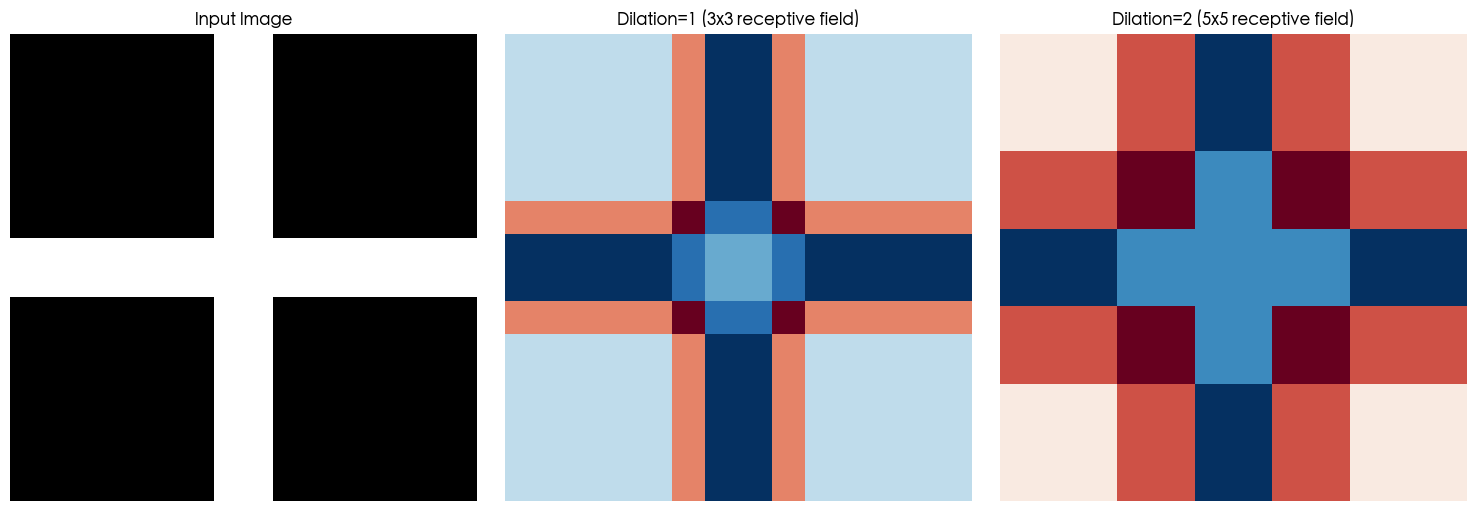

Larger dilation → larger receptive field → captures wider context


In [4]:
def dilated_conv2d(input_img, kernel, dilation=1):
    """
    2D dilated convolution
    """
    H, W = input_img.shape
    kH, kW = kernel.shape
    
    # Effective kernel size
    eff_kH = (kH - 1) * dilation + 1
    eff_kW = (kW - 1) * dilation + 1
    
    out_H = H - eff_kH + 1
    out_W = W - eff_kW + 1
    
    output = np.zeros((out_H, out_W))
    
    for i in range(out_H):
        for j in range(out_W):
            result = 0
            for ki in range(kH):
                for kj in range(kW):
                    img_i = i + ki * dilation
                    img_j = j + kj * dilation
                    result += input_img[img_i, img_j] * kernel[ki, kj]
            output[i, j] = result
    
    return output

# Create test image with pattern
img = np.zeros((16, 16))
img[7:9, :] = 1  # Horizontal line
img[:, 7:9] = 1  # Vertical line (cross)

# 3x3 edge detection kernel
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

# Apply with different dilations
result_d1 = dilated_conv2d(img, kernel, dilation=1)
result_d2 = dilated_conv2d(img, kernel, dilation=2)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(result_d1, cmap='RdBu')
axes[1].set_title('Dilation=1 (3x3 receptive field)')
axes[1].axis('off')

axes[2].imshow(result_d2, cmap='RdBu')
axes[2].set_title('Dilation=2 (5x5 receptive field)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Larger dilation → larger receptive field → captures wider context")

## 多尺度上下文模块

In [5]:
class MultiScaleContext:
    """Stack dilated convolutions with increasing dilation rates"""
    def __init__(self, kernel_size=3):
        self.kernel_size = kernel_size
        
        # Create kernels for each scale
        self.kernels = [
            np.random.randn(kernel_size, kernel_size) * 0.1
            for _ in range(4)
        ]
        
        # Dilation rates: 1, 2, 4, 8
        self.dilations = [1, 2, 4, 8]
    
    def forward(self, input_img):
        """
        Apply multi-scale dilated convolutions
        """
        outputs = []
        
        current = input_img
        for kernel, dilation in zip(self.kernels, self.dilations):
            # Apply dilated conv
            out = dilated_conv2d(current, kernel, dilation)
            outputs.append(out)
            
            # Pad back to original size (simplified)
            pad_h = (input_img.shape[0] - out.shape[0]) // 2
            pad_w = (input_img.shape[1] - out.shape[1]) // 2
            current = np.pad(out, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
            
            # Crop to match input size
            current = current[:input_img.shape[0], :input_img.shape[1]]
        
        return outputs, current

# Test multi-scale
msc = MultiScaleContext(kernel_size=3)
scales, final = msc.forward(img)

print(f"Receptive fields at each layer:")
for i, d in enumerate(msc.dilations):
    rf = 1 + 2 * d * (len(msc.dilations) - 1)
    print(f"  Layer {i+1} (dilation={d}): {rf}x{rf}")

Receptive fields at each layer:
  Layer 1 (dilation=1): 7x7
  Layer 2 (dilation=2): 13x13
  Layer 3 (dilation=4): 25x25
  Layer 4 (dilation=8): 49x49


## 关键要点

### 膨胀卷积：
- 在核权重之间插入零（空洞）
- **感受野**：$(k-1) \cdot d + 1$，其中 $k$=核大小，$d$=膨胀率
- **相同参数**作为标准卷积
- **更大上下文**且无需池化

### 优势：
- ✅ 感受野指数增长
- ✅ 无分辨率损失（与池化对比）
- ✅ 相同的参数数量
- ✅ 多尺度上下文聚合

### 应用：
- **语义分割**：密集预测任务
- **音频生成**：WaveNet
- **时间序列**：TCN（时间卷积网络）
- **任何需要大感受野的任务**

### 对比：
| 方法 | 感受野 | 分辨率 | 参数 |
|--------|----------------|------------|------------|
| 标准卷积 | 小 | 完整 | 低 |
| 池化 | 大 | 降低 | 低 |
| 大核 | 大 | 完整 | 高 |
| **膨胀卷积** | **大** | **完整** | **低** |